# SignVision

## 📊 Data Preparation & Augmentation

This cell sets up the data pipeline for training the sign language recognition model.

### 🎯 Purpose
- Load preprocessed hand sign image crops from directories
- Apply data augmentation to training images to improve model generalization
- Normalize pixel values for neural network input
- Create batch generators for efficient training

### 🔧 Configuration
- **Image Size**: 224×224 pixels (standard for transfer learning models)
- **Batch Size**: 32 images per batch
- **Data Structure**: Images organized in subdirectories by class label

### 🔄 Data Augmentation Techniques
Applied to **training set only**:
- **Rescaling**: Normalize pixels from [0-255] to [0-1]
- **Rotation**: Random rotation up to ±15°
- **Shifting**: Random horizontal/vertical shifts (10%)
- **Shearing**: Random shear transformations (10%)
- **Zooming**: Random zoom in/out (10%)
- **Horizontal Flip**: Random mirroring (⚠️ may not suit all signs)

Validation set receives **normalization only** for consistent evaluation.

### 📂 Expected Directory Structure
```
data_processed/crops/
├── train/
│   ├── 0/
│   ├── 1/
│   └── ...
└── val/
    ├── 0/
    ├── 1/
    └── ...
```

### ✅ Expected Output
- "Found X images belonging to Y classes" for both train and val sets
- Class mapping dictionary showing folder names → numeric labels

---

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = "E:/Downloads/sign_language/SignVision/data_processed/crops/train"
val_dir = "E:/Downloads/sign_language/SignVision/data_processed/crops/val"

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_ds = train_datagen.flow_from_directory(
    train_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical'
)
val_ds = val_datagen.flow_from_directory(
    val_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical'
)

print("Classes:", train_ds.class_indices)


Found 103 images belonging to 5 classes.


Found 31 images belonging to 5 classes.
Classes: {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4}


## 🏗️ Model Architecture - Transfer Learning with MobileNetV2

This cell builds the sign language classification model using **transfer learning**.

### 🎯 Purpose
- Leverage a pre-trained MobileNetV2 model (trained on ImageNet) as a feature extractor
- Add custom classification layers on top for sign language recognition
- Compile the model with appropriate loss function and optimizer

### 🧠 Model Architecture

#### Base Model: MobileNetV2
- **Pre-trained on**: ImageNet (1.4M images, 1000 classes)
- **Input Shape**: 224×224×3 (RGB images)
- **Configuration**: `include_top=False` - removes original classification layers
- **Initial State**: Frozen (weights not updated during initial training)

#### Custom Classification Head
```
MobileNetV2 (frozen)
    ↓
GlobalAveragePooling2D  → Reduces spatial dimensions to 1D feature vector
    ↓
Dense(128, ReLU)        → Learned feature transformation
    ↓
Dense(num_classes, Softmax) → Final classification layer
```

### 🔒 Transfer Learning Strategy
- **Frozen Base**: `base_model.trainable = False` prevents updating pre-trained weights
- **Why?**: Pre-trained features (edges, shapes, patterns) are already useful for hand detection
- **Later**: Can unfreeze and fine-tune top layers after initial training

### ⚙️ Compilation Settings
- **Optimizer**: Adam (adaptive learning rate)
- **Loss Function**: Categorical Crossentropy (multi-class classification)
- **Metrics**: Accuracy (% of correct predictions)

### 📊 Expected Output
Model summary showing:
- Total parameters (millions)
- Trainable vs non-trainable parameters
- Layer-by-layer architecture breakdown

### 💡 Why MobileNetV2?
✅ Lightweight & fast (suitable for mobile deployment)  
✅ Excellent accuracy-to-size ratio  
✅ Efficient for real-time inference  
✅ Perfect for SignVision's goal of accessible hand sign recognition

---

In [3]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # freeze base layers initially

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
outputs = Dense(train_ds.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=outputs)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 12s 1us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,597 (9.24 MB)

 Trainable params: 164,613 (643.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

## 🚀 Model Training

Train the model for 10 epochs on the prepared dataset.

### Configuration
- **Epochs**: 10 (complete passes through training data)
- **Training**: Uses augmented images from `train_ds`
- **Validation**: Evaluates on `val_ds` each epoch

### Expected Output
```
Epoch X/10
loss: X.XX - accuracy: X.XX - val_loss: X.XX - val_accuracy: X.XX
```

### What to Watch
✅ Accuracy increasing over epochs  
✅ Small gap between train & validation accuracy  
⚠️ If val_accuracy stops improving → potential overfitting

### Saved Results
`history` object stores loss & accuracy metrics for plotting.

---

In [4]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)


c:\Users\PC\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 522ms/step - accuracy: 0.4248 - loss: 1.7027

c:\Users\PC\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 963ms/step - accuracy: 0.4330 - loss: 1.6733 - val_accuracy: 0.8065 - val_loss: 0.8415
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 545ms/step - accuracy: 0.7816 - loss: 0.7786 - val_accuracy: 0.8710 - val_loss: 0.3631
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 519ms/step - accuracy: 0.8810 - loss: 0.3744 - val_accuracy: 0.9032 - val_loss: 0.1878
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 726ms/step - accuracy: 0.9843 - loss: 0.1442 - val_accuracy: 0.9032 - val_loss: 0.1500
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 551ms/step - accuracy: 0.9381 - loss: 0.1390 - val_accuracy: 0.9677 - val_loss: 0.0935
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 573ms/step - accuracy: 0.9922 - loss: 0.0718 - val_accuracy: 0.9677 - val_loss: 0.0816
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 613ms/step - accuracy: 0.9909 - loss: 0.0628 - val_accuracy: 0.9677 - val_loss: 0.0658
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 794ms/step - accuracy: 0.9596 - loss: 0.0574 - val_accuracy: 0.9355 - val_loss: 0.1071
Epo

## 📊 Training Performance Visualization

Plot training and validation accuracy curves to evaluate model learning.

### Purpose
- Visualize accuracy improvement over epochs
- Compare training vs validation performance
- Identify overfitting or underfitting patterns

### What to Look For
✅ **Both curves rising** → Model learning well  
✅ **Curves close together** → Good generalization  
⚠️ **Large gap** → Overfitting (train >> val)  
⚠️ **Both curves flat** → Underfitting (increase epochs/complexity)

---

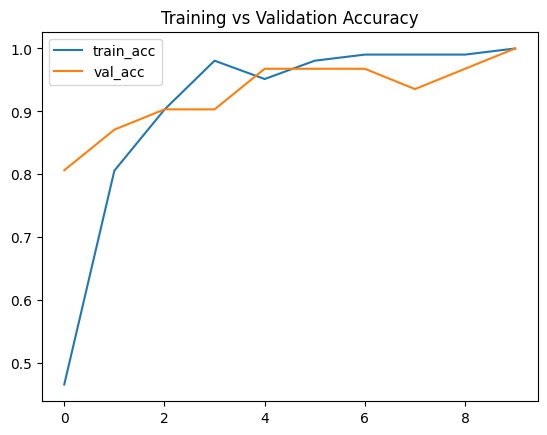

In [5]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.title("Training vs Validation Accuracy")
plt.show()


In [6]:
model.save("models/signvision_cnn.h5")


## Model Evaluation

This cell performs comprehensive evaluation of the trained model using validation data.

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
              precision    recall  f1-score   support

           0       0.20      0.20      0.20         5
           1       0.20      0.20      0.20         5
           2       0.20      0.20      0.20         5
           3       0.25      0.25      0.25         4
           4       0.42      0.42      0.42        12

    accuracy                           0.29        31
   macro avg       0.25      0.25      0.25        31
weighted avg       0.29      0.29      0.29        31



Text(50.722222222222214, 0.5, 'True')

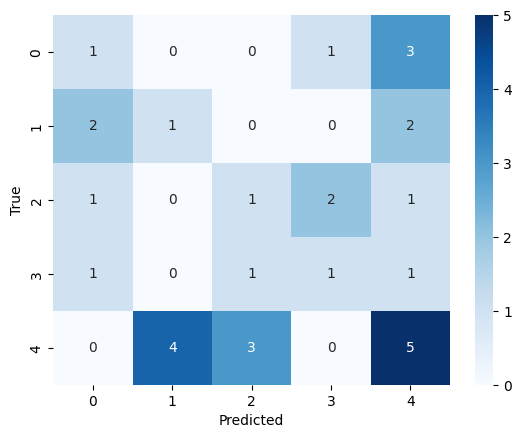

In [7]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

Y_pred = model.predict(val_ds)
y_pred = np.argmax(Y_pred, axis=1)

print(classification_report(val_ds.classes, y_pred, target_names=list(val_ds.class_indices.keys())))

cm = confusion_matrix(val_ds.classes, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')


In [8]:
# Replace MobileNetV2 with a simpler model that won't overfit:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dropout(0.5),  # High dropout to prevent overfitting
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')  # 5 classes
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

c:\Users\PC\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,605 (42.61 MB)

 Trainable params: 11,169,605 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
model.save("models/signvision_cnn_v2.h5")


In [10]:
# Replace your training data generator with this:

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,        # Increased from 15
    width_shift_range=0.2,    # Increased from 0.1
    height_shift_range=0.2,   # Increased from 0.1
    shear_range=0.2,          # Increased from 0.1
    zoom_range=0.2,           # Increased from 0.1
    brightness_range=[0.7, 1.3],  # NEW: brightness variation
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_ds = train_datagen.flow_from_directory(
    train_dir, 
    target_size=IMG_SIZE, 
    batch_size=16,            # REDUCED batch size for small dataset
    class_mode='categorical'
)

val_ds = val_datagen.flow_from_directory(
    val_dir, 
    target_size=IMG_SIZE, 
    batch_size=16,            # REDUCED batch size
    class_mode='categorical'
)

Found 103 images belonging to 5 classes.
Found 31 images belonging to 5 classes.


In [11]:
# Add this BEFORE model.fit():

import numpy as np
from sklearn.utils.class_weight import compute_class_weight

# Calculate class weights to balance the dataset
class_weights = compute_class_weight(
    'balanced',
    classes=np.array([0, 1, 2, 3, 4]),
    y=train_ds.classes
)
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

print("📊 Class weights:", class_weight_dict)
# This will give more importance to classes with fewer images

# Then train with weights:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,                    # INCREASED epochs (more passes over small data)
    class_weight=class_weight_dict  # ← CRITICAL: Balance the classes
)

📊 Class weights: {0: 1.2117647058823529, 1: 1.03, 2: 1.1444444444444444, 3: 1.2875, 4: 0.64375}


c:\Users\PC\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


InvalidArgumentError: Graph execution error:

Detected at node PyFunc defined at (most recent call last):
<stack traces unavailable>
TypeError: `generator` yielded an element that did not match the expected structure. The expected structure was (tf.float32, tf.float32, tf.float32), but the yielded element was (array([[[[0.45098042, 0.4431373 , 0.47450984],
         [0.53333336, 0.5294118 , 0.56078434],
         [0.49803925, 0.49803925, 0.5294118 ],
         ...,
         [0.36862746, 0.3529412 , 0.35686275],
         [0.36078432, 0.34509805, 0.34901962],
         [0.36078432, 0.34509805, 0.34901962]],

        [[0.5176471 , 0.5137255 , 0.54509807],
         [0.5294118 , 0.5254902 , 0.5568628 ],
         [0.4784314 , 0.4784314 , 0.50980395],
         ...,
         [0.3647059 , 0.34901962, 0.3529412 ],
         [0.3647059 , 0.34901962, 0.3529412 ],
         [0.3647059 , 0.34901962, 0.3529412 ]],

        [[0.5176471 , 0.5058824 , 0.5411765 ],
         [0.48627454, 0.4784314 , 0.5176471 ],
         [0.4784314 , 0.4784314 , 0.50980395],
         ...,
         [0.3647059 , 0.34901962, 0.3529412 ],
         [0.3647059 , 0.34901962, 0.3529412 ],
         [0.36078432, 0.34509805, 0.34901962]],

        ...,

        [[0.5411765 , 0.4039216 , 0.29411766],
         [0.5411765 , 0.4039216 , 0.29411766],
         [0.5411765 , 0.4039216 , 0.29411766],
         ...,
         [0.29411766, 0.28627452, 0.2901961 ],
         [0.32941177, 0.32156864, 0.3254902 ],
         [0.33333334, 0.3254902 , 0.32941177]],

        [[0.5411765 , 0.4039216 , 0.29411766],
         [0.5411765 , 0.4039216 , 0.29411766],
         [0.5411765 , 0.4039216 , 0.29411766],
         ...,
         [0.29411766, 0.28627452, 0.2901961 ],
         [0.31764707, 0.30980393, 0.3137255 ],
         [0.34117648, 0.33333334, 0.3372549 ]],

        [[0.5411765 , 0.4039216 , 0.29411766],
         [0.5411765 , 0.4039216 , 0.29411766],
         [0.5411765 , 0.4039216 , 0.29411766],
         ...,
         [0.29803923, 0.2901961 , 0.29411766],
         [0.3019608 , 0.29411766, 0.29803923],
         [0.34509805, 0.3372549 , 0.34117648]]],


       [[[0.5254902 , 0.46274513, 0.43529415],
         [0.5529412 , 0.49411768, 0.454902  ],
         [0.5529412 , 0.49411768, 0.454902  ],
         ...,
         [0.45098042, 0.35686275, 0.29803923],
         [0.45098042, 0.35686275, 0.29803923],
         [0.45098042, 0.35686275, 0.29803923]],

        [[0.5686275 , 0.5058824 , 0.4784314 ],
         [0.5686275 , 0.5058824 , 0.4784314 ],
         [0.54901963, 0.4901961 , 0.454902  ],
         ...,
         [0.45098042, 0.35686275, 0.29803923],
         [0.45098042, 0.35686275, 0.29803923],
         [0.45098042, 0.35686275, 0.29803923]],

        [[0.5529412 , 0.4901961 , 0.45882356],
         [0.5686275 , 0.5058824 , 0.4784314 ],
         [0.5647059 , 0.5019608 , 0.47450984],
         ...,
         [0.45098042, 0.35686275, 0.29803923],
         [0.45098042, 0.35686275, 0.29803923],
         [0.45098042, 0.35686275, 0.29803923]],

        ...,

        [[0.6627451 , 0.50980395, 0.40784317],
         [0.654902  , 0.5019608 , 0.40000004],
         [0.64705884, 0.49803925, 0.39607847],
         ...,
         [0.6313726 , 0.50980395, 0.39607847],
         [0.6313726 , 0.5058824 , 0.39607847],
         [0.6313726 , 0.5058824 , 0.39607847]],

        [[0.6431373 , 0.49803925, 0.3921569 ],
         [0.6431373 , 0.49803925, 0.39607847],
         [0.6627451 , 0.50980395, 0.40784317],
         ...,
         [0.6313726 , 0.5176471 , 0.39607847],
         [0.6313726 , 0.5137255 , 0.39607847],
         [0.6313726 , 0.5137255 , 0.39607847]],

        [[0.6313726 , 0.4901961 , 0.38431376],
         [0.6431373 , 0.5019608 , 0.39607847],
         [0.6666667 , 0.52156866, 0.41960788],
         ...,
         [0.6666667 , 0.54509807, 0.42352945],
         [0.65882355, 0.5372549 , 0.41960788],
         [0.64705884, 0.53333336, 0.40784317]]],


       [[[0.3803922 , 0.30980393, 0.2392157 ],
         [0.3803922 , 0.30980393, 0.2392157 ],
         [0.3803922 , 0.30980393, 0.2392157 ],
         ...,
         [0.69411767, 0.67058825, 0.58431375],
         [0.69411767, 0.67058825, 0.58431375],
         [0.69803923, 0.6745098 , 0.5882353 ]],

        [[0.3803922 , 0.30980393, 0.2392157 ],
         [0.3803922 , 0.30980393, 0.2392157 ],
         [0.3803922 , 0.30980393, 0.2392157 ],
         ...,
         [0.7019608 , 0.6784314 , 0.5921569 ],
         [0.7019608 , 0.6784314 , 0.5921569 ],
         [0.7019608 , 0.6784314 , 0.5921569 ]],

        [[0.3803922 , 0.30980393, 0.2392157 ],
         [0.3803922 , 0.30980393, 0.2392157 ],
         [0.3803922 , 0.30980393, 0.2392157 ],
         ...,
         [0.6901961 , 0.6666667 , 0.58431375],
         [0.6901961 , 0.6666667 , 0.58431375],
         [0.6901961 , 0.6666667 , 0.58431375]],

        ...,

        [[0.24705884, 0.2392157 , 0.24313727],
         [0.25490198, 0.24705884, 0.2509804 ],
         [0.25882354, 0.25490198, 0.25882354],
         ...,
         [0.48235297, 0.3921569 , 0.31764707],
         [0.4901961 , 0.40784317, 0.3372549 ],
         [0.5019608 , 0.42352945, 0.34509805]],

        [[0.2901961 , 0.28235295, 0.28627452],
         [0.3019608 , 0.29411766, 0.29803923],
         [0.30588236, 0.3019608 , 0.3019608 ],
         ...,
         [0.48235297, 0.3921569 , 0.31764707],
         [0.48627454, 0.4039216 , 0.33333334],
         [0.5019608 , 0.42352945, 0.34509805]],

        [[0.29411766, 0.28627452, 0.2901961 ],
         [0.2901961 , 0.28235295, 0.28627452],
         [0.2901961 , 0.28235295, 0.28627452],
         ...,
         [0.48235297, 0.3921569 , 0.3137255 ],
         [0.48235297, 0.40000004, 0.32941177],
         [0.5019608 , 0.42352945, 0.34117648]]],


       ...,


       [[[0.39607847, 0.28627452, 0.24705884],
         [0.41960788, 0.30588236, 0.26666668],
         [0.43137258, 0.31764707, 0.28235295],
         ...,
         [0.5882353 , 0.5254902 , 0.43137258],
         [0.59607846, 0.53333336, 0.43921572],
         [0.6       , 0.5372549 , 0.4431373 ]],

        [[0.39607847, 0.28627452, 0.24705884],
         [0.4156863 , 0.3019608 , 0.2627451 ],
         [0.427451  , 0.3137255 , 0.2784314 ],
         ...,
         [0.61960787, 0.5568628 , 0.45882356],
         [0.61960787, 0.5568628 , 0.45882356],
         [0.61960787, 0.5568628 , 0.45882356]],

        [[0.39607847, 0.28627452, 0.24705884],
         [0.41176474, 0.29803923, 0.25882354],
         [0.427451  , 0.3137255 , 0.2784314 ],
         ...,
         [0.61960787, 0.5568628 , 0.45882356],
         [0.6156863 , 0.5529412 , 0.454902  ],
         [0.6156863 , 0.5529412 , 0.454902  ]],

        ...,

        [[0.25882354, 0.23529413, 0.23529413],
         [0.25882354, 0.23529413, 0.23529413],
         [0.25490198, 0.23137257, 0.23137257],
         ...,
         [0.16862746, 0.16862746, 0.16862746],
         [0.17254902, 0.17254902, 0.17254902],
         [0.18039216, 0.18039216, 0.18039216]],

        [[0.2509804 , 0.227451  , 0.227451  ],
         [0.24705884, 0.22352943, 0.22352943],
         [0.24705884, 0.22352943, 0.22352943],
         ...,
         [0.17254902, 0.17254902, 0.17254902],
         [0.16470589, 0.16470589, 0.16470589],
         [0.18431373, 0.18431373, 0.18431373]],

        [[0.2509804 , 0.227451  , 0.227451  ],
         [0.25490198, 0.23137257, 0.23137257],
         [0.25490198, 0.23137257, 0.23137257],
         ...,
         [0.18823531, 0.18823531, 0.18823531],
         [0.18039216, 0.18039216, 0.18039216],
         [0.1764706 , 0.1764706 , 0.1764706 ]]],


       [[[0.2627451 , 0.21568629, 0.22352943],
         [0.2627451 , 0.21568629, 0.22352943],
         [0.2627451 , 0.21568629, 0.22352943],
         ...,
         [1.        , 1.        , 0.8745099 ],
         [1.        , 1.        , 0.86666673],
         [1.        , 1.        , 0.86666673]],

        [[0.2627451 , 0.21568629, 0.22352943],
         [0.2627451 , 0.21568629, 0.22352943],
         [0.2627451 , 0.21568629, 0.22352943],
         ...,
         [1.        , 1.        , 0.8745099 ],
         [1.        , 1.        , 0.86666673],
         [1.        , 1.        , 0.86666673]],

        [[0.2627451 , 0.21568629, 0.22352943],
         [0.2627451 , 0.21568629, 0.22352943],
         [0.2627451 , 0.21568629, 0.22352943],
         ...,
         [1.        , 1.        , 0.8745099 ],
         [1.        , 1.        , 0.86666673],
         [1.        , 1.        , 0.86666673]],

        ...,

        [[0.3254902 , 0.34117648, 0.38431376],
         [0.3254902 , 0.34117648, 0.38431376],
         [0.3254902 , 0.34117648, 0.38431376],
         ...,
         [0.427451  , 0.4039216 , 0.41176474],
         [0.3921569 , 0.37254903, 0.37647063],
         [0.3921569 , 0.37647063, 0.3803922 ]],

        [[0.3254902 , 0.34117648, 0.38431376],
         [0.3254902 , 0.34117648, 0.38431376],
         [0.3254902 , 0.34117648, 0.38431376],
         ...,
         [0.427451  , 0.4039216 , 0.41176474],
         [0.3921569 , 0.37254903, 0.37647063],
         [0.3921569 , 0.37254903, 0.37647063]],

        [[0.3254902 , 0.34117648, 0.38431376],
         [0.3254902 , 0.34117648, 0.38431376],
         [0.3254902 , 0.34117648, 0.38431376],
         ...,
         [0.427451  , 0.4039216 , 0.41176474],
         [0.3921569 , 0.37254903, 0.37647063],
         [0.3921569 , 0.37254903, 0.37647063]]],


       [[[0.97647065, 0.9333334 , 0.81568635],
         [0.97647065, 0.9333334 , 0.81568635],
         [0.97647065, 0.9333334 , 0.81568635],
         ...,
         [0.8980393 , 0.7411765 , 0.68235296],
         [0.8745099 , 0.7058824 , 0.6313726 ],
         [0.86274517, 0.68235296, 0.6039216 ]],

        [[0.97647065, 0.9333334 , 0.81568635],
         [0.97647065, 0.9333334 , 0.81568635],
         [0.97647065, 0.9333334 , 0.81568635],
         ...,
         [0.8705883 , 0.7019608 , 0.6392157 ],
         [0.854902  , 0.6745098 , 0.59607846],
         [0.83921576, 0.65882355, 0.5647059 ]],

        [[0.97647065, 0.9333334 , 0.81568635],
         [0.97647065, 0.9333334 , 0.81568635],
         [0.97647065, 0.9333334 , 0.81568635],
         ...,
         [0.854902  , 0.67058825, 0.6039216 ],
         [0.8313726 , 0.6431373 , 0.56078434],
         [0.8196079 , 0.61960787, 0.52156866]],

        ...,

        [[0.7686275 , 0.6745098 , 0.58431375],
         [0.81568635, 0.7176471 , 0.61960787],
         [0.8588236 , 0.7607844 , 0.65882355],
         ...,
         [0.18823531, 0.18431373, 0.21176472],
         [0.18823531, 0.18431373, 0.21176472],
         [0.17254902, 0.16862746, 0.19607845]],

        [[1.        , 0.8980393 , 0.77647066],
         [1.        , 0.90196085, 0.77647066],
         [1.        , 0.90196085, 0.7686275 ],
         ...,
         [0.17254902, 0.16862746, 0.19607845],
         [0.18431373, 0.18039216, 0.20392159],
         [0.17254902, 0.16862746, 0.18823531]],

        [[1.        , 0.8941177 , 0.75294125],
         [1.        , 0.89019614, 0.7490196 ],
         [1.        , 0.882353  , 0.7411765 ],
         ...,
         [0.18823531, 0.18431373, 0.20784315],
         [0.18823531, 0.18431373, 0.20784315],
         [0.18823531, 0.18431373, 0.20784315]]]], dtype=float32), array([[0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]], dtype=float32)).
Traceback (most recent call last):

  File "c:\Users\PC\venv\Lib\site-packages\tensorflow\python\data\ops\from_generator_op.py", line 204, in generator_py_func
    flattened_values = nest.flatten_up_to(output_types, values)
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "c:\Users\PC\venv\Lib\site-packages\tensorflow\python\data\util\nest.py", line 237, in flatten_up_to
    return nest_util.flatten_up_to(
           ^^^^^^^^^^^^^^^^^^^^^^^^

  File "c:\Users\PC\venv\Lib\site-packages\tensorflow\python\util\nest_util.py", line 1541, in flatten_up_to
    return _tf_data_flatten_up_to(shallow_tree, input_tree)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "c:\Users\PC\venv\Lib\site-packages\tensorflow\python\util\nest_util.py", line 1570, in _tf_data_flatten_up_to
    _tf_data_assert_shallow_structure(shallow_tree, input_tree)

  File "c:\Users\PC\venv\Lib\site-packages\tensorflow\python\util\nest_util.py", line 1427, in _tf_data_assert_shallow_structure
    raise ValueError(

ValueError: The two structures don't have the same sequence length. Input structure has length 2, while shallow structure has length 3.


The above exception was the direct cause of the following exception:


Traceback (most recent call last):

  File "c:\Users\PC\venv\Lib\site-packages\tensorflow\python\ops\script_ops.py", line 269, in __call__
    ret = func(*args)
          ^^^^^^^^^^^

  File "c:\Users\PC\venv\Lib\site-packages\tensorflow\python\autograph\impl\api.py", line 643, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

  File "c:\Users\PC\venv\Lib\site-packages\tensorflow\python\data\ops\from_generator_op.py", line 206, in generator_py_func
    raise TypeError(

TypeError: `generator` yielded an element that did not match the expected structure. The expected structure was (tf.float32, tf.float32, tf.float32), but the yielded element was (array([[[[0.45098042, 0.4431373 , 0.47450984],
         [0.53333336, 0.5294118 , 0.56078434],
         [0.49803925, 0.49803925, 0.5294118 ],
         ...,
         [0.36862746, 0.3529412 , 0.35686275],
         [0.36078432, 0.34509805, 0.34901962],
         [0.36078432, 0.34509805, 0.34901962]],

        [[0.5176471 , 0.5137255 , 0.54509807],
         [0.5294118 , 0.5254902 , 0.5568628 ],
         [0.4784314 , 0.4784314 , 0.50980395],
         ...,
         [0.3647059 , 0.34901962, 0.3529412 ],
         [0.3647059 , 0.34901962, 0.3529412 ],
         [0.3647059 , 0.34901962, 0.3529412 ]],

        [[0.5176471 , 0.5058824 , 0.5411765 ],
         [0.48627454, 0.4784314 , 0.5176471 ],
         [0.4784314 , 0.4784314 , 0.50980395],
         ...,
         [0.3647059 , 0.34901962, 0.3529412 ],
         [0.3647059 , 0.34901962, 0.3529412 ],
         [0.36078432, 0.34509805, 0.34901962]],

        ...,

        [[0.5411765 , 0.4039216 , 0.29411766],
         [0.5411765 , 0.4039216 , 0.29411766],
         [0.5411765 , 0.4039216 , 0.29411766],
         ...,
         [0.29411766, 0.28627452, 0.2901961 ],
         [0.32941177, 0.32156864, 0.3254902 ],
         [0.33333334, 0.3254902 , 0.32941177]],

        [[0.5411765 , 0.4039216 , 0.29411766],
         [0.5411765 , 0.4039216 , 0.29411766],
         [0.5411765 , 0.4039216 , 0.29411766],
         ...,
         [0.29411766, 0.28627452, 0.2901961 ],
         [0.31764707, 0.30980393, 0.3137255 ],
         [0.34117648, 0.33333334, 0.3372549 ]],

        [[0.5411765 , 0.4039216 , 0.29411766],
         [0.5411765 , 0.4039216 , 0.29411766],
         [0.5411765 , 0.4039216 , 0.29411766],
         ...,
         [0.29803923, 0.2901961 , 0.29411766],
         [0.3019608 , 0.29411766, 0.29803923],
         [0.34509805, 0.3372549 , 0.34117648]]],


       [[[0.5254902 , 0.46274513, 0.43529415],
         [0.5529412 , 0.49411768, 0.454902  ],
         [0.5529412 , 0.49411768, 0.454902  ],
         ...,
         [0.45098042, 0.35686275, 0.29803923],
         [0.45098042, 0.35686275, 0.29803923],
         [0.45098042, 0.35686275, 0.29803923]],

        [[0.5686275 , 0.5058824 , 0.4784314 ],
         [0.5686275 , 0.5058824 , 0.4784314 ],
         [0.54901963, 0.4901961 , 0.454902  ],
         ...,
         [0.45098042, 0.35686275, 0.29803923],
         [0.45098042, 0.35686275, 0.29803923],
         [0.45098042, 0.35686275, 0.29803923]],

        [[0.5529412 , 0.4901961 , 0.45882356],
         [0.5686275 , 0.5058824 , 0.4784314 ],
         [0.5647059 , 0.5019608 , 0.47450984],
         ...,
         [0.45098042, 0.35686275, 0.29803923],
         [0.45098042, 0.35686275, 0.29803923],
         [0.45098042, 0.35686275, 0.29803923]],

        ...,

        [[0.6627451 , 0.50980395, 0.40784317],
         [0.654902  , 0.5019608 , 0.40000004],
         [0.64705884, 0.49803925, 0.39607847],
         ...,
         [0.6313726 , 0.50980395, 0.39607847],
         [0.6313726 , 0.5058824 , 0.39607847],
         [0.6313726 , 0.5058824 , 0.39607847]],

        [[0.6431373 , 0.49803925, 0.3921569 ],
         [0.6431373 , 0.49803925, 0.39607847],
         [0.6627451 , 0.50980395, 0.40784317],
         ...,
         [0.6313726 , 0.5176471 , 0.39607847],
         [0.6313726 , 0.5137255 , 0.39607847],
         [0.6313726 , 0.5137255 , 0.39607847]],

        [[0.6313726 , 0.4901961 , 0.38431376],
         [0.6431373 , 0.5019608 , 0.39607847],
         [0.6666667 , 0.52156866, 0.41960788],
         ...,
         [0.6666667 , 0.54509807, 0.42352945],
         [0.65882355, 0.5372549 , 0.41960788],
         [0.64705884, 0.53333336, 0.40784317]]],


       [[[0.3803922 , 0.30980393, 0.2392157 ],
         [0.3803922 , 0.30980393, 0.2392157 ],
         [0.3803922 , 0.30980393, 0.2392157 ],
         ...,
         [0.69411767, 0.67058825, 0.58431375],
         [0.69411767, 0.67058825, 0.58431375],
         [0.69803923, 0.6745098 , 0.5882353 ]],

        [[0.3803922 , 0.30980393, 0.2392157 ],
         [0.3803922 , 0.30980393, 0.2392157 ],
         [0.3803922 , 0.30980393, 0.2392157 ],
         ...,
         [0.7019608 , 0.6784314 , 0.5921569 ],
         [0.7019608 , 0.6784314 , 0.5921569 ],
         [0.7019608 , 0.6784314 , 0.5921569 ]],

        [[0.3803922 , 0.30980393, 0.2392157 ],
         [0.3803922 , 0.30980393, 0.2392157 ],
         [0.3803922 , 0.30980393, 0.2392157 ],
         ...,
         [0.6901961 , 0.6666667 , 0.58431375],
         [0.6901961 , 0.6666667 , 0.58431375],
         [0.6901961 , 0.6666667 , 0.58431375]],

        ...,

        [[0.24705884, 0.2392157 , 0.24313727],
         [0.25490198, 0.24705884, 0.2509804 ],
         [0.25882354, 0.25490198, 0.25882354],
         ...,
         [0.48235297, 0.3921569 , 0.31764707],
         [0.4901961 , 0.40784317, 0.3372549 ],
         [0.5019608 , 0.42352945, 0.34509805]],

        [[0.2901961 , 0.28235295, 0.28627452],
         [0.3019608 , 0.29411766, 0.29803923],
         [0.30588236, 0.3019608 , 0.3019608 ],
         ...,
         [0.48235297, 0.3921569 , 0.31764707],
         [0.48627454, 0.4039216 , 0.33333334],
         [0.5019608 , 0.42352945, 0.34509805]],

        [[0.29411766, 0.28627452, 0.2901961 ],
         [0.2901961 , 0.28235295, 0.28627452],
         [0.2901961 , 0.28235295, 0.28627452],
         ...,
         [0.48235297, 0.3921569 , 0.3137255 ],
         [0.48235297, 0.40000004, 0.32941177],
         [0.5019608 , 0.42352945, 0.34117648]]],


       ...,


       [[[0.39607847, 0.28627452, 0.24705884],
         [0.41960788, 0.30588236, 0.26666668],
         [0.43137258, 0.31764707, 0.28235295],
         ...,
         [0.5882353 , 0.5254902 , 0.43137258],
         [0.59607846, 0.53333336, 0.43921572],
         [0.6       , 0.5372549 , 0.4431373 ]],

        [[0.39607847, 0.28627452, 0.24705884],
         [0.4156863 , 0.3019608 , 0.2627451 ],
         [0.427451  , 0.3137255 , 0.2784314 ],
         ...,
         [0.61960787, 0.5568628 , 0.45882356],
         [0.61960787, 0.5568628 , 0.45882356],
         [0.61960787, 0.5568628 , 0.45882356]],

        [[0.39607847, 0.28627452, 0.24705884],
         [0.41176474, 0.29803923, 0.25882354],
         [0.427451  , 0.3137255 , 0.2784314 ],
         ...,
         [0.61960787, 0.5568628 , 0.45882356],
         [0.6156863 , 0.5529412 , 0.454902  ],
         [0.6156863 , 0.5529412 , 0.454902  ]],

        ...,

        [[0.25882354, 0.23529413, 0.23529413],
         [0.25882354, 0.23529413, 0.23529413],
         [0.25490198, 0.23137257, 0.23137257],
         ...,
         [0.16862746, 0.16862746, 0.16862746],
         [0.17254902, 0.17254902, 0.17254902],
         [0.18039216, 0.18039216, 0.18039216]],

        [[0.2509804 , 0.227451  , 0.227451  ],
         [0.24705884, 0.22352943, 0.22352943],
         [0.24705884, 0.22352943, 0.22352943],
         ...,
         [0.17254902, 0.17254902, 0.17254902],
         [0.16470589, 0.16470589, 0.16470589],
         [0.18431373, 0.18431373, 0.18431373]],

        [[0.2509804 , 0.227451  , 0.227451  ],
         [0.25490198, 0.23137257, 0.23137257],
         [0.25490198, 0.23137257, 0.23137257],
         ...,
         [0.18823531, 0.18823531, 0.18823531],
         [0.18039216, 0.18039216, 0.18039216],
         [0.1764706 , 0.1764706 , 0.1764706 ]]],


       [[[0.2627451 , 0.21568629, 0.22352943],
         [0.2627451 , 0.21568629, 0.22352943],
         [0.2627451 , 0.21568629, 0.22352943],
         ...,
         [1.        , 1.        , 0.8745099 ],
         [1.        , 1.        , 0.86666673],
         [1.        , 1.        , 0.86666673]],

        [[0.2627451 , 0.21568629, 0.22352943],
         [0.2627451 , 0.21568629, 0.22352943],
         [0.2627451 , 0.21568629, 0.22352943],
         ...,
         [1.        , 1.        , 0.8745099 ],
         [1.        , 1.        , 0.86666673],
         [1.        , 1.        , 0.86666673]],

        [[0.2627451 , 0.21568629, 0.22352943],
         [0.2627451 , 0.21568629, 0.22352943],
         [0.2627451 , 0.21568629, 0.22352943],
         ...,
         [1.        , 1.        , 0.8745099 ],
         [1.        , 1.        , 0.86666673],
         [1.        , 1.        , 0.86666673]],

        ...,

        [[0.3254902 , 0.34117648, 0.38431376],
         [0.3254902 , 0.34117648, 0.38431376],
         [0.3254902 , 0.34117648, 0.38431376],
         ...,
         [0.427451  , 0.4039216 , 0.41176474],
         [0.3921569 , 0.37254903, 0.37647063],
         [0.3921569 , 0.37647063, 0.3803922 ]],

        [[0.3254902 , 0.34117648, 0.38431376],
         [0.3254902 , 0.34117648, 0.38431376],
         [0.3254902 , 0.34117648, 0.38431376],
         ...,
         [0.427451  , 0.4039216 , 0.41176474],
         [0.3921569 , 0.37254903, 0.37647063],
         [0.3921569 , 0.37254903, 0.37647063]],

        [[0.3254902 , 0.34117648, 0.38431376],
         [0.3254902 , 0.34117648, 0.38431376],
         [0.3254902 , 0.34117648, 0.38431376],
         ...,
         [0.427451  , 0.4039216 , 0.41176474],
         [0.3921569 , 0.37254903, 0.37647063],
         [0.3921569 , 0.37254903, 0.37647063]]],


       [[[0.97647065, 0.9333334 , 0.81568635],
         [0.97647065, 0.9333334 , 0.81568635],
         [0.97647065, 0.9333334 , 0.81568635],
         ...,
         [0.8980393 , 0.7411765 , 0.68235296],
         [0.8745099 , 0.7058824 , 0.6313726 ],
         [0.86274517, 0.68235296, 0.6039216 ]],

        [[0.97647065, 0.9333334 , 0.81568635],
         [0.97647065, 0.9333334 , 0.81568635],
         [0.97647065, 0.9333334 , 0.81568635],
         ...,
         [0.8705883 , 0.7019608 , 0.6392157 ],
         [0.854902  , 0.6745098 , 0.59607846],
         [0.83921576, 0.65882355, 0.5647059 ]],

        [[0.97647065, 0.9333334 , 0.81568635],
         [0.97647065, 0.9333334 , 0.81568635],
         [0.97647065, 0.9333334 , 0.81568635],
         ...,
         [0.854902  , 0.67058825, 0.6039216 ],
         [0.8313726 , 0.6431373 , 0.56078434],
         [0.8196079 , 0.61960787, 0.52156866]],

        ...,

        [[0.7686275 , 0.6745098 , 0.58431375],
         [0.81568635, 0.7176471 , 0.61960787],
         [0.8588236 , 0.7607844 , 0.65882355],
         ...,
         [0.18823531, 0.18431373, 0.21176472],
         [0.18823531, 0.18431373, 0.21176472],
         [0.17254902, 0.16862746, 0.19607845]],

        [[1.        , 0.8980393 , 0.77647066],
         [1.        , 0.90196085, 0.77647066],
         [1.        , 0.90196085, 0.7686275 ],
         ...,
         [0.17254902, 0.16862746, 0.19607845],
         [0.18431373, 0.18039216, 0.20392159],
         [0.17254902, 0.16862746, 0.18823531]],

        [[1.        , 0.8941177 , 0.75294125],
         [1.        , 0.89019614, 0.7490196 ],
         [1.        , 0.882353  , 0.7411765 ],
         ...,
         [0.18823531, 0.18431373, 0.20784315],
         [0.18823531, 0.18431373, 0.20784315],
         [0.18823531, 0.18431373, 0.20784315]]]], dtype=float32), array([[0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]], dtype=float32)).


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]] [Op:__inference_one_step_on_iterator_14627]